In [370]:
# It is seen that both methods do the optimization quite well. However, deterministic shot 
# distribution always needs a minimum shot value required per expectation value, and below this
# they become biased. This is not the case with random sampling, as in some experiments they have
# done the estimator remais unbiased with as little as a single shot per expectation term.

# Rosalin modifies iCANS to incorporate weighted random sampling of the Hamiltonian terms
# It's the Rosalin frugal shot optimizer. By including the WRS, it makes it 'doubly stochastic'.

"""
Rosalin takes several hyper-parameters:
    - min_shots: minimum # of shots used to estimate the expectation of each term of the Hamiltonian.
    - mu: running average constant in [0,1]. It's used to control how quickly the number of shots 
      recommended for each gradient component changes.
    - b: regulatization bias. Should be kept small, but >0.
    - lr: learning rate. It must be < 2/L with L = sum(|c_i|)
    
Because Rosaling has a state that must be preserved between opt steps, we can create a class.
"""

class RosalinQml:

    def __init__(self, qnodes, coeffs, min_shots, mu=0.99, b=1e-6, lr=0.07):
        self.qnodes = qnodes
        self.coeffs = coeffs

        self.lipschitz = pnp.sum(pnp.abs(coeffs))

        if lr > 2 / self.lipschitz:
            raise ValueError("The learning rate must be less than ", 2 / self.lipschitz)

        # hyperparameters
        # mu is used to create the smooth versions of g and S. 
        # b is used to calculate the new number of shots in a new iteration.
        # lr (or alpha) is the learning rate. It is changed or not based on the version of iCANS that we are using.
        self.min_shots = min_shots
        self.mu = mu  # running average constant
        self.b = b    # regularization bias
        self.lr = lr  # learning rate

        # keep track of the total number of shots used
        self.shots_used = 0
        # total number of iterations
        self.k = 0
        # Number of shots per parameter, CHECK THIS!!
        self.s = pnp.zeros_like(params, dtype=pnp.float64) + min_shots

        # Running average of the parameter gradients
        self.chi = None
        # Running average of the variance of the parameter gradients
        self.xi = None

    def estimate_hamiltonian(self, params, shots):
        """Returns an array containing length ``shots`` single-shot estimates
        of the Hamiltonian. The shots are distributed randomly over
        the terms in the Hamiltonian, as per a Multinomial distribution.

        Since we are performing single-shot estimates, the QNodes must be
        set to 'sample' mode.
        """

        # determine the shot probability per term
        prob_shots = pnp.abs(coeffs) / pnp.sum(pnp.abs(coeffs))

        # construct the multinomial distribution, and sample from it to determine how many shots to apply per term
        si = multinomial(n=shots, p=prob_shots)
        shots_per_term = si.rvs()[0]

        results = []
        # The qnodes are the parts of the hamiltonian. 
        for h, c, p, s in zip(self.qnodes, self.coeffs, prob_shots, shots_per_term):

            # if the number of shots is 0, do nothing
            if s == 0:
                continue

            # evaluate the QNode corresponding to the Hamiltonian term
            res = h(params, shots=int(s))
            
            # res is an array of results from evaluating the hamiltonian.
            if s == 1:
                res = pnp.array([res])

            # Note that, unlike above, we divide each term by the
            # probability per shot. This is because we are sampling one at a time.
            results.append(c * res / p)

        # concatenate makes it a big list of resutls, instead of a list of lists where each smaller list is
        # the results of the evaluation for a certain h_i.
        return pnp.concatenate(results)

    # This function is the same as iEvaluate in the pseudocode.
    def evaluate_grad_var(self, i, params, shots):
        """Evaluate the gradient, as well as the variance in the gradient,
        for the ith parameter in params, using the parameter-shift rule.
        """
        shift = pnp.zeros_like(params)
        shift[i] = pnp.pi / 2

        # The params are changed a bit. 
        shift_forward = self.estimate_hamiltonian(params + shift, shots)
        shift_backward = self.estimate_hamiltonian(params - shift, shots)
        
        g = pnp.mean(shift_forward - shift_backward) / 2
        s = pnp.var((shift_forward - shift_backward) / 2, ddof=1)

        return g, s

    # This function gives back the new theta. It also updates the xi, chi and s.
    def step(self, params):
        """Perform a single step of the Rosalin optimizer."""
        # keep track of the number of shots run
        self.shots_used += int(2 * pnp.sum(self.s))

        # compute the gradient, as well as the variance in the gradient,
        # using the number of shots determined by the array s.
        grad = []
        S = []

        p_ind = list(pnp.ndindex(*params.shape))
        # print("p_ind is:", p_ind)
        # print("params is:", params)
        # print("the shape of the params is:", params.shape)

        for l in p_ind:
            # loop through each parameter, performing
            # the parameter-shift rule
            g_, s_ = self.evaluate_grad_var(l, params, self.s[l])
            grad.append(g_)
            S.append(s_)

        grad = np.reshape(pnp.stack(grad), params.shape)
        S = np.reshape(pnp.stack(S), params.shape)

        # gradient descent update
        params = params - self.lr * grad

        if self.xi is None:
            self.chi = pnp.zeros_like(params, dtype=np.float64)
            self.xi = pnp.zeros_like(params, dtype=np.float64)

        # running average of the gradient variance
        self.xi = self.mu * self.xi + (1 - self.mu) * S
        xi = self.xi / (1 - self.mu ** (self.k + 1))

        # running average of the gradient
        self.chi = self.mu * self.chi + (1 - self.mu) * grad
        chi = self.chi / (1 - self.mu ** (self.k + 1))

        # determine the new optimum shots distribution for the next
        # iteration of the optimizer
        s = pnp.ceil(
            (2 * self.lipschitz * self.lr * xi)
            / ((2 - self.lipschitz * self.lr) * (chi ** 2 + self.b * (self.mu ** self.k)))
        )

        # apply an upper and lower bound on the new shot distributions,to avoid the number of shots reducing 
        # below min(2, min_shots), or growing too significantly.
        gamma = (
            (self.lr - self.lipschitz * self.lr ** 2 / 2) * chi ** 2
            - xi * self.lipschitz * self.lr ** 2 / (2 * s)
        ) / s

        argmax_gamma = pnp.unravel_index(pnp.argmax(gamma), gamma.shape)
        smax = s[argmax_gamma]
        # I am adding this here because smax goes below 2 and then it makes self.s all zeroes
        if smax < 2:
            smax = 2
        self.s = pnp.clip(s, min(2, self.min_shots), smax)

        self.k += 1
        return params


Step 1: analytic cost = -0.3544774955886738, noisy cost = -1.2999999999999998, shots_used = 720
Step 2: analytic cost = 0.0826535388229935, noisy cost = 0.52, shots_used = 864
Step 3: analytic cost = 0.3357229178794676, noisy cost = 0.5, shots_used = 1008
Step 4: analytic cost = -0.9696078519109848, noisy cost = -0.66, shots_used = 1152
Step 5: analytic cost = -1.838500720306507, noisy cost = -3.4, shots_used = 1366
Step 6: analytic cost = -1.7497315531943403, noisy cost = -2.18, shots_used = 1582
Step 7: analytic cost = 0.5338419161849126, noisy cost = 1.1800000000000002, shots_used = 1726
Step 8: analytic cost = 4.059292864759225, noisy cost = 4.6, shots_used = 1870
Step 9: analytic cost = -2.3456687948532657, noisy cost = -3.1999999999999997, shots_used = 2086
Step 10: analytic cost = 0.3226740958923773, noisy cost = 0.08000000000000052, shots_used = 2230
Step 11: analytic cost = -0.09138435510868015, noisy cost = -0.76, shots_used = 2446
Step 12: analytic cost = -2.2237921972217345

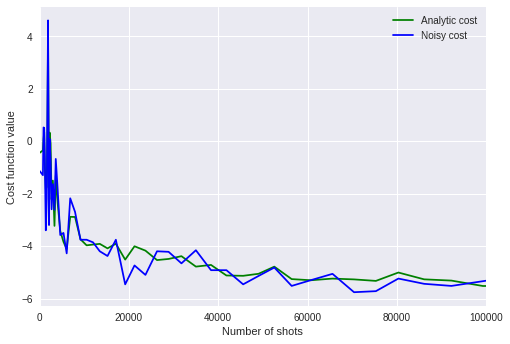

In [372]:
# Their implementation
import pennylane as qml

from pennylane import numpy as pnp
from matplotlib import pyplot as plt
from pennylane.templates.layers import StronglyEntanglingLayers

# set the random seed
np.random.seed(4)


# Defining the observable
coeffs = [1, 1, 1, 3, 3, 3]

obs = [
  qml.PauliZ(0) @ qml.PauliZ(1),
  qml.PauliZ(0) @ qml.PauliZ(2),
  qml.PauliZ(1) @ qml.PauliZ(2),
  qml.PauliZ(0),
  qml.PauliZ(1),
  qml.PauliZ(2)
]


# parameters for the structure of the quantum circuit
num_layers = 4
num_wires = 3

total_shots = 100000

# create a device that calculates exact expectation values
analytic_dev = qml.device("default.qubit", wires=num_wires, shots=None)
# create a device that estimates expectation values using a finite number of shots
rosalin_device = qml.device("default.qubit", wires=num_wires, shots=100)
# These cost functions are defined to calculate the cost of the h_i's in noisy and noiseless ways. 
cost_fun_analytic = qml.dot(coeffs, qml.map(StronglyEntanglingLayers, obs, device=analytic_dev))
cost_fun_noisy = qml.dot(coeffs, qml.map(StronglyEntanglingLayers, obs, device=rosalin_device))

# param_shape is: (4, 3, 3). 4 layers, 3 qubits and each operation of a qubit on a layer is a rotation on x, y and z
param_shape = StronglyEntanglingLayers.shape(n_layers=num_layers, n_wires=num_wires)

init_params = pnp.random.uniform(low=0.0, high=2*np.pi, size=param_shape, requires_grad=True)

# Defining the Rosalin optimizer
# qml.map maps the circuit (defined by the StrongEntanglingLayers template) to the different h_i's, to compute
# the expectation values of the different observables
qnodes = qml.map(StronglyEntanglingLayers, obs, device=rosalin_device, measure="sample")
opt = RosalinQml(qnodes, coeffs, min_shots=10)
params = init_params

cost_res_analytic = [cost_fun_analytic(params)]
cost_res_noisy = [cost_fun_noisy(params)]
shots_rosalin = [0]

cont = 1
while (opt.shots_used < total_shots):
    params = opt.step(params)
    # Evaluate the noisy and noiseless cost functions and add them to their respective lists
    cost_res_analytic.append(cost_fun_analytic(params))
    cost_res_noisy.append(cost_fun_noisy(params))
    
    shots_rosalin.append(opt.shots_used)
    print(f"Step {cont}: analytic cost = {cost_res_analytic[-1]}, noisy cost = {cost_res_noisy[-1]}, shots_used = {shots_rosalin[-1]}")
    cont += 1
    

# plotting  
plt.style.use("seaborn")
plt.plot(shots_rosalin, cost_res_analytic, "g", label="Analytic cost")
plt.plot(shots_rosalin, cost_res_noisy, "b", label="Noisy cost")


plt.ylabel("Cost function value")
plt.xlabel("Number of shots")
plt.legend()
plt.xlim(0, 100000)
plt.show()


In [292]:
"""
Helper function used to create the circuit whose parameters we are trying to optimize
"""

import cirq
import random


# Why don't create the circuit inside the function?
def create_circuit(circuit, theta, number_qubits, location_unitaries):
    """
    Inputs
    - circuit: cirq Circuit() object.
    - theta: collection of 19 rotation angles from [0, 2*pi]. The order of theta is: first the unitaries, each one with 9 parameters. Then the last Ry's.
    - number_qubits: number of qubits in the circuit (or wires).
    - location_unitaries: this shows what the starting position of the unitaries is. This can be seen in the iCANS paper.
    
    Returns
    - A cirq circuit object.
    """
    
    for i in range(number_qubits):
            circuit.append(cirq.H(cirq.LineQubit(i)))
    
    number_unitaries = len(location_unitaries)
            
    # Creation of unitaries
    for i in range(number_unitaries):
        first_qubit = location_unitaries[i]
        second_qubit = first_qubit + 1
    
        # Check indexes
        parameters = theta[i*9:i*(9)+9]
        
        rot_1 = cirq.ry(parameters[0])
        rot_2 = cirq.ry(parameters[1])
        circuit.append(rot_1(cirq.LineQubit(first_qubit)))
        circuit.append(rot_2(cirq.LineQubit(second_qubit)))
        
        rot_1 = cirq.rz(parameters[2])
        rot_2 = cirq.rz(parameters[3])
        circuit.append(rot_1(cirq.LineQubit(first_qubit)))
        circuit.append(rot_2(cirq.LineQubit(second_qubit)))
        
        circuit.append(cirq.CNOT(cirq.LineQubit(first_qubit),cirq.LineQubit(second_qubit)))
        
        rot_1 = cirq.rz(parameters[4])
        rot_2 = cirq.ry(parameters[5])
        circuit.append(rot_1(cirq.LineQubit(first_qubit)))
        circuit.append(rot_2(cirq.LineQubit(second_qubit)))
        
        circuit.append(cirq.CNOT(cirq.LineQubit(second_qubit),cirq.LineQubit(first_qubit)))
        
        rot_2 = cirq.ry(parameters[6])
        circuit.append(rot_2(cirq.LineQubit(second_qubit)))
        
        circuit.append(cirq.CNOT(cirq.LineQubit(first_qubit),cirq.LineQubit(second_qubit)))
        
        rot_1 = cirq.rz(parameters[7])
        rot_2 = cirq.rz(parameters[8])
        circuit.append(rot_1(cirq.LineQubit(first_qubit)))
        circuit.append(rot_2(cirq.LineQubit(second_qubit)))
        
    # Last Ry rotations
    # Check if this notation works
    parameters = theta[-number_qubits:]
    for i in range(number_qubits):
        rot = cirq.ry(parameters[i])
        circuit.append(rot(cirq.LineQubit(i)))

    return(circuit)

In [362]:
# My version of Rosalin, changing Pennylane to Cirq
class RosalinCirq:

    # I add here params
    def __init__(self, params, coeffs, hamiltonian_terms, min_shots, mu=0.99, b=1e-6, lr=0.07):
        # self.qnodes = qnodes
        self.qubits = qubits
        self.coeffs = coeffs
        self.params = params
        self.hamiltonian_terms = hamiltonian_terms
        
        self.lipschitz = np.sum(np.abs(coeffs))

        if lr > 2 / self.lipschitz:
            raise ValueError("The learning rate must be less than ", 2 / self.lipschitz)

        # hyperparameters
        self.min_shots = min_shots
        self.mu = mu  # running average constant
        self.b = b    # regularization bias
        self.lr = lr  # learning rate

        # keep track of the total number of shots used
        self.shots_used = 0
        # total number of iterations
        self.k = 0
        
        # Number of shots per parameter
        self.s = np.zeros(len(params), dtype=np.float64) + min_shots

        # Running average of the parameter gradients
        self.chi = None
        # Running average of the variance of the parameter gradients
        self.xi = None

    # This is then used to calculate H+ and H-.
    def estimate_hamiltonian(self, params, shots_per_term):
        """Returns an array containing length ``shots`` single-shot estimates
        of the Hamiltonian. The shots are distributed randomly over
        the terms in the Hamiltonian, as per a Multinomial distribution.

        Since we are performing single-shot estimates, the QNodes must be
        set to 'sample' mode.
        """
        
        circuit = cirq.Circuit()
        # Change this so it's not hardcoded
        circuit = create_circuit(circuit, params, 3, [0, 1])

        expectation_results = []
            
        sum_coeffs = sum(self.coeffs)
        probabilities = [coeff/sum_coeffs for coeff in self.coeffs]
        
        simulator = cirq.Simulator()
        ev_list = simulator.simulate_expectation_values(
            circuit,
            observables=self.hamiltonian_terms,
        )
        
        # Here we transform the exact expectation value of the h_i's into a number between [0,1] so we can 
        # sample from the binomial
        p_list = [(x.real+1)/2 for x in ev_list]
        
        expectation_results = []
        
        for i in range(len(self.coeffs)):
            results_binomial = np.random.binomial(1, p_list[i], size=shots_per_term[i])
            # Transform de results of the binomial from {0,1} to {-1,1} and then do the formula 
            # c_i*expectation/p_i
            expectations = [coeffs[i]*(result*2-1)/probabilities[i] for result in results_binomial]
            expectation_results += expectations
        
        expectation_results = np.array(expectation_results)
                
        return expectation_results
    
    def hamiltonian_exact_result(self, params):
        circuit = cirq.Circuit()
        # Change this so it's not hardcoded
        circuit = create_circuit(circuit, params, 3, [0, 1])
        
        simulator = cirq.Simulator()
        ev_list = simulator.simulate_expectation_values(
            circuit,
            observables=self.hamiltonian_terms,
        )
        
        exact_result = sum([self.coeffs[i]*ev_list[i] for i in range(len(self.coeffs))])
        return exact_result.real
        
    def evaluate_grad_var(self, i, params, shots):
        """
        Evaluate the gradient, as well as the variance in the gradient,
        for the ith parameter in params, using the parameter-shift rule.
        """
        shift = np.zeros(len(params))
        shift[i] = np.pi / 2
                
        prob_shots = np.abs(self.coeffs) / np.sum(np.abs(self.coeffs))
        si = multinomial(n=shots, p=prob_shots)
        
        shots_per_term = si.rvs()[0]

        shift_forward = self.estimate_hamiltonian(params + shift, shots_per_term)
        shift_backward = self.estimate_hamiltonian(params - shift, shots_per_term)
        
        g = np.mean(shift_forward - shift_backward) / 2
        # This is how they calculate the variance, from an array of results from running the circuit
        s = np.var((shift_forward - shift_backward) / 2, ddof=1)

        return g, s

    def step(self, params):
        """Perform a single step of the Rosalin optimizer."""
        # keep track of the number of shots run
        self.shots_used += int(2 * np.sum(self.s))

        # compute the gradient, as well as the variance in the gradient, using the number of shots determined by the array s.
        grad = []
        S = []
        
        for i in range(len(params)):
            # loop through each parameter, performing the parameter-shift rule
            g_, s_ = self.evaluate_grad_var(i, params, self.s[i])
            grad.append(g_)
            S.append(s_)
            
        grad = np.array(grad)
        S = np.array(S)

        # gradient descent update
        params = params - self.lr * grad
        
        if self.xi is None:
            self.chi = np.zeros(len(params), dtype=np.float64)
            self.xi = np.zeros(len(params), dtype=np.float64)

        # running average of the gradient variance
        self.xi = self.mu * self.xi + (1 - self.mu) * S
        xi = self.xi / (1 - self.mu ** (self.k + 1))

        # running average of the gradient
        self.chi = self.mu * self.chi + (1 - self.mu) * grad
        chi = self.chi / (1 - self.mu ** (self.k + 1))

        # determine the new optimum shots distribution for the next iteration of the optimizer
        op_for_ceiling = (2 * self.lipschitz * self.lr * xi) / ((2 - self.lipschitz * self.lr) * (chi ** 2 + self.b * (self.mu ** self.k)))
        
        # New number of shots for each part of the observable
        s = np.ceil(op_for_ceiling)
        # print("s without clipping is:", s)

        # apply an upper and lower bound on the new shot distributions, to avoid the number of shots reducing 
        # below min(2, min_shots), or growing too significantly.
        gamma = (
            (self.lr - self.lipschitz * self.lr ** 2 / 2) * chi ** 2
            - xi * self.lipschitz * self.lr ** 2 / (2 * s)
        ) / s

        
        smax = s[np.argmax(gamma)]
        if smax < 2:
            smax = 2
            
        # .astype changes it to int. Changing here min to max
        self.s = np.clip(s, min(2, self.min_shots), smax).astype(int)

        self.k += 1
        return params

In [373]:
"""
This function is used to obtain the results of the Rosalin optimization so they can be plotted (in the next cell).
"""

def calculate_results(hamiltonian_terms, nfes, min_shots):
    number_qubits = 3
    
    # Number of parameters for the circuit showed in the iCANS paper
    number_parameters = (number_qubits - 1)*9 + number_qubits
    init_params = np.array([random.uniform(0, 2*np.pi) for _ in range(number_parameters)])

    # Call the optimizer class
    opt = RosalinCirq(init_params, coeffs, hamiltonian_terms, min_shots)
    
    # To do the estimation of the Hamiltonian with the newly found theta and see how the result of the 
    # algorithm is evolving
    prob_shots = np.abs(coeffs) / np.sum(np.abs(coeffs))
    cost_rosalin_noisy = [np.inf]
    cost_rosalin_analytic = [np.inf]
    shots_rosalin = [0]

    params = init_params

    cont = 1

    while (opt.shots_used < nfes):
        # New theta after a new iteration
        params = opt.step(params)

        # We calculate how many shots we have done
        shots_rosalin.append(opt.shots_used)
        # How many shots have been used in this iteration
        used_shots = shots_rosalin[-1] - shots_rosalin[-2]

        # Calculate the estimation for the noisy cost with the new params of this iteration
        si = multinomial(n=100,p=prob_shots)
        shots_per_term = si.rvs()[0]
        estimations = opt.estimate_hamiltonian(params, shots_per_term)
        opt.shots_used += 100
        
        average = sum(estimations)/len(estimations)        
        cost_rosalin_noisy.append(average)
        
        exact_cost = opt.hamiltonian_exact_result(params)
        cost_rosalin_analytic.append(exact_cost)
        
        print(f"Step {cont}: analytic cost = {cost_rosalin_analytic[-1]}, noisy cost = {cost_rosalin_noisy[-1]}, shots_used = {shots_rosalin[-1]}")

        cont += 1
        
    return (shots_rosalin, cost_rosalin_noisy, cost_rosalin_analytic)

Step 1: analytic cost = -3.1679410338401794, noisy cost = -1.68, shots_used = 420
Step 2: analytic cost = -0.6404825299978256, noisy cost = -1.2, shots_used = 646
Step 3: analytic cost = 1.1301808506250381, noisy cost = 1.44, shots_used = 830
Step 4: analytic cost = 0.33244583010673523, noisy cost = 2.88, shots_used = 1056
Step 5: analytic cost = -1.6875813603401184, noisy cost = -0.48, shots_used = 1324
Step 6: analytic cost = -2.9673353135585785, noisy cost = -2.64, shots_used = 1882
Step 7: analytic cost = -3.5036531388759613, noisy cost = -2.64, shots_used = 2444
Step 8: analytic cost = -4.730833634734154, noisy cost = -3.12, shots_used = 3048
Step 9: analytic cost = -4.59017950296402, noisy cost = -4.32, shots_used = 3736
Step 10: analytic cost = -4.580155074596405, noisy cost = -5.28, shots_used = 4382
Step 11: analytic cost = -4.569118469953537, noisy cost = -4.32, shots_used = 5194
Step 12: analytic cost = -4.526567250490189, noisy cost = -6.96, shots_used = 5924
Step 13: analy

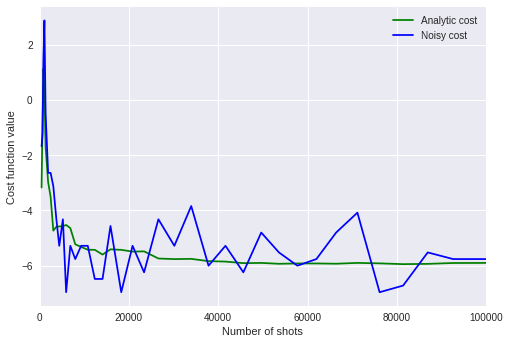

In [374]:
"""
This code defines the hamiltonian we are using and calls the function calculate_results, and then plots the 
results.
"""

import copy
import numpy as np

number_shots = 100000
# minimum number of shots to estimate each theta_i. The number of min_shots is adapted as the iterations pass.
min_shots = 10

qubits = [cirq.LineQubit(0), cirq.LineQubit(1), cirq.LineQubit(2)]

Z0 = cirq.PauliString(cirq.Z(qubits[0]))
Z1 = cirq.PauliString(cirq.Z(qubits[1]))
Z2 = cirq.PauliString(cirq.Z(qubits[2]))
hamiltonian_terms = [Z0*Z1, Z0*Z2, Z1*Z2, Z0, Z1, Z2] 

shots_rosalin, cost_rosalin_noisy, cost_rosalin_analytic = calculate_results(hamiltonian_terms, number_shots, min_shots)

plt.style.use("seaborn")
plt.plot(shots_rosalin, cost_rosalin_analytic, "g", label="Analytic cost")
plt.plot(shots_rosalin, cost_rosalin_noisy, "b", label="Noisy cost")

plt.ylabel("Cost function value")
plt.xlabel("Number of shots")
plt.legend()
plt.xlim(0, number_shots)
plt.show()

In [294]:
"""
This piece of code is to find the eigenvalues of different hamiltonians, to then see how the optimization
using Rosalin is performing.

Eigenvalues of different Hamiltonians with 3 qubits:

- H = Z0Z1. Eigenvalues are: [-1. -1. -1. -1.  1.  1.  1.  1.]
- H = Z0Z2. Eigenvalues are: [-1. -1. -1. -1.  1.  1.  1.  1.]
- H = Z1Z2. Eigenvalues are: [-1. -1. -1. -1.  1.  1.  1.  1.]
- H = 3*Z0. Eigenvalues are: 3*[-1. -1. -1. -1.  1.  1.  1.  1.] = [-3. -3. -3. -3.  3.  3.  3.  3.]
- H = 3*Z1. Eigenvalues are: 3*[-1. -1. -1. -1.  1.  1.  1.  1.] = [-3. -3. -3. -3.  3.  3.  3.  3.]
- H = 3*Z2. Eigenvalues are: 3*[-1. -1. -1. -1.  1.  1.  1.  1.] = [-3. -3. -3. -3.  3.  3.  3.  3.]

"""


import openfermion
from openfermion import QubitOperator

"""hamiltonian = QubitOperator('X0 X1') + QubitOperator('Y0 Y1') + QubitOperator('Z0 Z1') + QubitOperator('X0 X2') +\
              QubitOperator('Y0 Y2') + QubitOperator('Z0 Z2') + QubitOperator('X1 X2') + QubitOperator('Y1 Y2') +\
              QubitOperator('Z1 Z2') + 3*QubitOperator('Z0') + 3*QubitOperator('Z1') + 3*QubitOperator('Z2')"""

hamiltonian = 3*QubitOperator('Z2')

print(type(hamiltonian))

sparse_mat = openfermion.get_sparse_operator(hamiltonian, n_qubits=3) # type: scipy.sparse.csr_matrix
mat = sparse_mat.toarray() # type: np.ndarray
w, v = np.linalg.eigh(mat)

print("eigenvalues are:", w)
print("The smallest eigenvalue is:", min(w))


<class 'openfermion.ops.operators.qubit_operator.QubitOperator'>
eigenvalues are: [-3. -3. -3. -3.  3.  3.  3.  3.]
The smallest eigenvalue is: -3.0
